In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy.linalg import solve
from scipy.integrate import quad
from scipy.sparse.linalg import LinearOperator

In [77]:
N: np.float64 = 9
K: np.float64 = 84

a: np.float64 = np.pi * (N + 10)
b: np.float64 = a + K/50 + 2

p: np.float64 = K * np.exp(10*N/K)
q: np.float64 = N * np.sin(np.pow(K, N)) + 2*K

print(f'S = [{a}, {b}]')
print(f'p,q = {p}, {q}')

#mgmv

S = [59.690260418206066, 63.370260418206065]
p,q = 245.24197354677395, 166.06164107197927


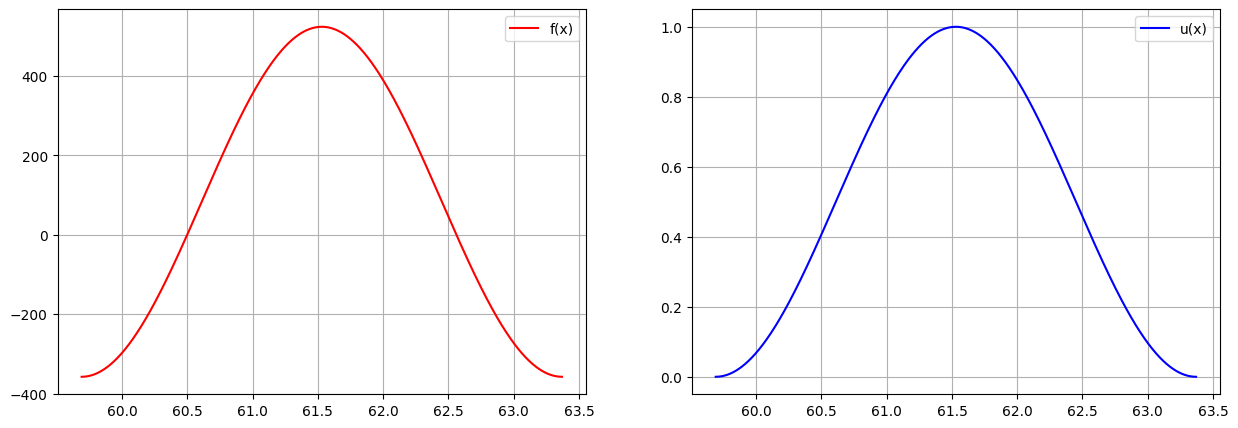

In [78]:
def u(x: np.float64) -> np.float64:
    return np.pow(np.sin(np.pi * (x - b) / (b - a)), 2)

def du(x: np.float64) -> np.float64:
    return np.pi * np.sin(2 * np.pi * (x - b) / (b - a)) / (b - a)

def ddu(x: np.float64) -> np.float64:
    return 2 * np.pow(np.pi, 2) * np.cos(2 * np.pi * (x - b) / (b - a)) / np.pow(b - a, 2)

def f(x: np.float64) -> np.float64:
    return -p*ddu(x) + q*u(x)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(a, b, 1000)
axs[0].plot(x, f(x), label='f(x)', color='red')
axs[1].plot(x, u(x), label='u(x)', color='blue')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

plt.show()

In [79]:
def funvect(func, n: np.float64) -> np.ndarray:
    n += 1
    x, h = np.linspace(a, b, n+1, retstep=True)
    xfunc = lambda x: x*func(x)
    vect = np.zeros(n-1)

    for i in range(1, n):
        vect[i-1] = quad(xfunc, x[i-1], x[i])[0] - x[i-1]*quad(func, x[i-1], x[i])[0] + x[i+1]*quad(func, x[i], x[i+1])[0] - quad(xfunc, x[i], x[i+1])[0]
    return vect * np.power(h, -2)

def FEMoperator(vect: np.ndarray) -> np.ndarray:
    h = (b-a) / vect.size

    mtr1, mtr2 = np.zeros_like(vect), np.zeros_like(vect)
    mtr1[:] += 2*vect
    mtr1[1:] -= vect[:-1]
    mtr1[:-1] -= vect[1:]

    mtr2[:] += 4*vect
    mtr2[1:] += vect[:-1]
    mtr2[:-1] += vect[1:]

    return p/(np.pow(h, 2)) * mtr1 + q/6.0 * mtr2

def createOperator(n: np.int64) -> LinearOperator:
    return LinearOperator((n, n), matvec=FEMoperator)

def createMatrix(A: LinearOperator) -> np.ndarray:
    n = A.shape[0]
    return np.column_stack([A(np.eye(n)[:, i]) for i in range(n)])

In [80]:
def SeidelMethod(A: LinearOperator, vct: np.ndarray[np.float64], x0 = None, maxit = None, eps = 1e-10):
    n = vct.size
    if x0 is None:      x = np.zeros(n)
    else:               x = x0
    if maxit is None:   maxit = n*10

    r = vct - A.matvec(x)
    rhop, p = None, None
    first = True
    for i in range(maxit):
        if np.linalg.norm(r) < eps:
            return x
        
        z = A.matvec(r)
        rhoc = np.dot(r, z)

        if i == 0:
            p = np.empty_like(r)
            p[:] = z[:]
        else:
            beta = rhoc / rhop
            p *= beta
            p += z
        q = A.matvec(p)
        alpha = rhoc / np.dot(p, q)
        x += alpha*p
        r -= alpha*q
        rhop = rhoc
    
    return x

k = 5
v = np.random.uniform(1, 3, k)
print(f'Operator solution: {SeidelMethod(createOperator(k), v)}')
print(f'Matrix solution: {solve(createMatrix(createOperator(k)), v)}')

Operator solution: [0.00618503 0.00892867 0.00883569 0.00647761 0.003805  ]
Matrix solution: [0.00618503 0.00892867 0.00883569 0.00647761 0.003805  ]


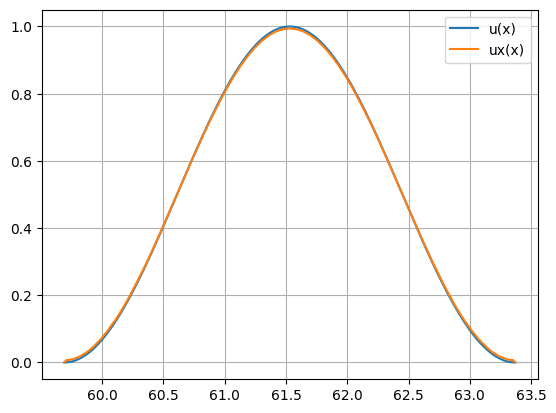

Time: 0.01914144


In [83]:
def cont(x: np.ndarray) -> np.ndarray:
    xc = np.zeros(2*x.size - 1)
    xc[::2] = x
    xc[1::2] = 0.5 * xc[:-2:2] + 0.5 * xc[2::2]
    return xc

def proj(x: np.ndarray) -> np.ndarray:
    xp = np.zeros(x.size // 2 + 1)
    xp[1:-1] = 0.25*x[1:-2:2] + 0.5*x[2:-1:2] + 0.25*x[3::2]
    xp[0] = 0.75*x[0] + 0.25*x[1]
    xp[-1] = 0.75*x[-1] + 0.25*x[-2]
    return xp

def mgmv(k: np.int64, x: np.ndarray, b: np.ndarray, nu: np.int64) -> np.ndarray:
    if k == 0: return SeidelMethod(createOperator(b.size), b)

    n = b.size
    A = createOperator(n)
    xnu = SeidelMethod(A, b, maxit=nu)
    r = proj(b - A(xnu))
    e = np.zeros(r.size)

    e1 = mgmv(k-1, e, r, nu)
    e = np.copy(e1)
    xnu += cont(e)
    return xnu

def solver(k: np.int64, x: np.ndarray, b: np.ndarray, nu: np.int64):
    alpha1 = np.zeros(x.size)
    start = time.time()
    while True:
        alpha = mgmv(k, alpha1, b, nu)
        if np.linalg.norm(alpha1 - alpha, ord=2) < 1e-5:
            break
        alpha1 = alpha.copy()
    end = time.time()
    return alpha, np.round(end - start, 8)

n = 257
xarr = np.linspace(a, b, n+2)
ux, t = solver(2, np.zeros(n), funvect(f, n), 20)
ux = np.array([0.0] + ux.tolist() + [0.0])

plt.plot(xarr, u(xarr), label='u(x)')
plt.plot(xarr, ux, label='ux(x)')
plt.legend()
plt.grid()
plt.show()
print(f'Time: {t}')


In [105]:
dims = np.array([np.pow(2, i) + 1 for i in range(8, 13)], dtype=np.int64)
def tableFiller() -> pd.DataFrame:
    k = np.int64(np.linspace(1, 10, 10))
    nu = np.int64(np.linspace(10, 100, 10))
    table = {n: pd.DataFrame(np.nan, index=k, columns=nu) for n in dims[::-1]}
    for i, df in enumerate(list(table.values())[:3]):
        for j, kv in enumerate(k[:7+i]):
            for m, nuv in enumerate(nu):
                df.iloc[j, m] = solver(kv, np.zeros(dims[-1-i]), funvect(f, dims[-1-i]), nuv)[1]
    for i, df in enumerate(list(table.values())[-2:]):
        for j, kv in enumerate(k):
            for m, nuv in enumerate(nu):
                df.iloc[j, m] = solver(kv, np.zeros(dims[i]), funvect(f, dims[i]), nuv)[1]
    return table

tdict = tableFiller()

ValueError: operands could not be broadcast together with shapes (2,) (3,) (2,) 

MGMV n = 256

In [100]:
dims = np.array([np.pow(2, i) + 1 for i in range(8, 13)], dtype=np.int64)
dims

array([ 257,  513, 1025, 2049, 4097])

In [104]:
tdict[1025]

,10,20,30,40,50,60,70,80,90,100
1,0.669245,0.686788,0.676151,0.686170,0.716123,0.737996,0.686963,0.676836,0.683538,0.727066
2,0.218373,0.230384,0.229386,0.228389,0.223399,0.216422,0.255311,0.254750,0.246379,0.226429
3,0.055846,0.069813,0.073805,0.079757,0.083390,0.086151,0.078473,0.083420,0.085365,0.116572
4,0.016999,0.019155,0.032942,0.033409,0.048048,0.050109,0.049999,0.059503,0.066141,0.070605
5,0.008721,0.017267,0.032777,0.033782,0.031271,0.049984,0.033424,0.066786,0.049310,0.064829
6,0.002399,0.014493,0.017705,0.033469,0.033610,0.032423,0.046319,0.050015,0.061824,0.066538
7,0.016942,0.014807,0.017294,0.033284,0.033666,0.050423,0.048200,0.052120,0.066557,0.060519
8,0.016486,0.029590,0.031145,0.033406,0.033484,0.049802,0.047940,0.052121,0.050122,0.067818
9,0.010970,0.018950,0.025931,0.032916,0.036899,0.043919,0.049864,0.053859,0.062872,0.064828
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
